# Applying an impact model for optimization of hydroelectric dam management driven by a time series of runoff data
# Author: 2020, John Methven
### Adaptation to Jupyter notebook, 2021: Judith Berner

In [1]:
import matplotlib.pyplot as plt
#import cartopy.crs as ccrs
import numpy as np
from scipy import optimize
from scipy import signal
from netCDF4 import Dataset
import datetime
from datetime import date
from datetime import timedelta
import readera_runoff_series as re
import xarray as xr

### Can be run with CMIP6 2019.10 kernel

 ###   Adapted from the dam operation model of Hirsch et al (2014) by John Methven 
 ###   This is called as a function from the main code

 ####   Input: 
 ####   :runoffarr  - input time series for runoff data
 ####   :dt         - runoff accumulation interval per record
 ####   :catcharea  - catchment area for the dam
 ####   :kappa      - parameter relating reservoir depth to volume
 ####   :hmax       - maximum water head (constraint on optimization)
 ####   :hmin       - minimum water head
 ####   :wmax       - maximum flow rate through turbines
 ####   :wmin       - minimum flow rate to maintain some power generation
 ####   :rmax       - maximum relief flow rate, bypassing turbines in flood
 ####   :sigma      - operational efficiency of power generation by dam
 ####   Output: 
 ####   :inflow     - input time series for inflow to reservoir  
 ####   :x          - output time series for water head at dam
 ####   :w          - output solution for optimum flow rate through turbines
 ####   :r          - output solution for relief flow rate
 ####   :gout       - value of time integrated generation for optimum solution (MW-days)


In [2]:
def damop_model(runoffarr, dt, catcharea, kappa, hmax, hmin, wmax, wmin, rmax, sigma):
    print()
    print('damop_model has been called with the constraints:')
    print('wmax = ',wmax,'   wmin = ',wmin,'   hmax = ',hmax,'   hmin = ',hmin)
    #
    # Convert runoff data from units of m to an equivalent inflow in m^3 s^-1
    # Assume that the same runoff rate applies to the entire catchment area for dam
    #
    runoffave = np.mean(runoffarr)
    inflow = catcharea*runoffarr/dt
    n = len(inflow)
    inmax = max(inflow)
    #
    # Set parameter used to control computational mode using filter similar to Robert-Asselin
    # Recommend 0 because filter introduces an offset of W relative to I in optimization.
    #
    alpha = 0.0
    #
    # Apply running mean to the inflow data if required for smoother solution 
    # to the optimisation. Averaging window length = nwin.
    #
    nwin = 3
    inflow = running_mean(inflow, nwin)
    #
    # Scale mu so that the sum of generation over time points is approx one.
    # This gives a better numerical solution in the optimisation for max generation
    # by reducing numerical truncation error in the calculation.
    #
    mu = 1.0/(n*sigma*wmax*hmax)
    #
    # The dam management optimization model is set up in the mathematical form of a 
    # quadratic programming problem.
    # The only input time series is the inflow to the reservoir.
    # The model solves for the water head at the dam maximizing power generation.
    # This then gives the flow rate through the turbines.
    # However, contraints are applied on maximum and minimum water level 
    # and maximum/minimum flow rate through the turbines.
    #
    # The equation for generation can be written in the form
    # 
    # G = 0.5*H^T P H + q^T H
    #
    # where H is the head time series we are solving for (a 1-D array) and 
    # P is a matrix and q is also a 1-D time series (scaled inflow).
    # The notation ^T means the transpose of the matrix. 
    # Quadratic programming aims to minimize -G which is equivalent to max(G).
    #
    q = -mu*sigma*inflow
    umat = np.zeros((n, n))
    inmat = np.zeros((n, n))
    cmat = np.zeros((n, n))
    for i in range(n):
        umat[i, i] = 1
        inmat[i, i] = inflow[i]

    for j in range(n-2):
        i = j+1
        cmat[i, i-1] = -1 + 0.5*alpha
        cmat[i, i]   = -alpha
        cmat[i, i+1] = 1 - 0.5*alpha
    
    pscal = mu*sigma*(kappa/dt)*cmat
    wscal = -0.5*(kappa/dt)*cmat
    #
    # Set constraints on the water head at the dam: hmin <= h <= hmax
    # Optimization requires that constraints actually need to be applied in form:
    # Amat x <= b  (where in this problem the vector x is head time series, h).
    # For Amat x >= b it is necessary to re-arrange to -Amat x <= -b.
    # Therefore to apply hmin <= h <= hmax, the matrix Amat is the unit matrix.
    #
    hscal = umat
    hmaxcons = np.ones(n)*hmax
    hmincons = np.ones(n)*hmin    
    #
    # Set constraints on the flow rate 
    # based on the parameters Wmax, Rmax and Wmin.
    # The form of the contraints means that it must be applied to range of W*h:
    # Wmin*hmin <= W*h <= (Wmax+Rmax)*hmax
    #
    gscal = wscal + inmat
    gmaxcons = np.zeros(n)
    gmincons = np.zeros(n)
    for i in range(n):
        gmaxcons[i] = (wmax+rmax)*hmax
        gmincons[i] = wmin*0.5*(hmin+hmax)
    #
    # Construct a single matrix describing Amat and vector for constraint values b
    # in the form required by optimize.minimize
    #
    vmat = np.concatenate((gscal, -gscal, hscal, -hscal), axis=0)
    vcons = np.concatenate((gmaxcons, -gmincons, hmaxcons, -hmincons))
    
    print('Now apply quadratic minimization technique')
    
    def gen(x, sign=1.):
        return sign * (0.5*np.dot(x.T, np.dot(pscal, x)) + np.dot(q.T, x))
    
    def jac(x, sign=1.):
        return sign * (np.dot(x.T, pscal) + q.T)
    
    cons = {'type':'ineq',
            'fun':lambda x: vcons - np.dot(vmat, x),
            'jac':lambda x: -vmat}
    
    opt = {'disp':True, 'maxiter':100, 'ftol':1e-08}

    #
    # Obtain solution by minimization nouter times. Smooth the input first guess 
    # and results for head, h, which removes noise and any numerical instability in 
    # optimal solution for the flow rate time series, W.
    # Note that the minimize method does not always find a solution consistent 
    # with the contraints imposed (depending on the first guess data) and these
    # failed attempts are not included in the average solution.
    #
    nouter = 3
    istsuccess = 1
    ic = -1
    afac = 0.5
    xinit = hmax*(afac + 0.1*np.random.randn(n))
    nwin = min([41, 2*round(0.2*n)+1])
    print('running mean window length, nwin = ',nwin)
    xinit = running_mean(xinit, nwin)
    
    for io in range(nouter):
    #while istsuccess == 1:
        #
        # First guess values for x (water head).
        # Random variation on top of constant level.
        # Smooth to reduce 2-grid noise in input data.
        #
        ic = ic+1
        res_cons = optimize.minimize(gen, xinit, jac=jac, constraints=cons,
                                 method='SLSQP', options=opt)
        xup = res_cons['x']
        fup = res_cons['fun']  
        stexit = res_cons['status']
    
        if stexit != 4:
            if istsuccess == 1:
                x = xup
                x = running_mean(x, nwin)
                xinit = x
                f = fup
                print('Constrained optimization')
                print(res_cons)
                print('iter ',ic,' f = ',f)
                istsuccess = 0
            else:
                if (fup/f) < 2:
                    afac = float(ic+1)/nouter
                    x = afac*x + (1-afac)*xup
                    x = running_mean(x, nwin)
                    xinit = x
                    f = afac*f + (1-afac)*fup
                    print('iter ',ic,' f = ',f)
        if ic == nouter:
            print(nouter,' outer iterations finished without reaching result')
            istsuccess = 1
    # end outer loop
    
    #
    # Optimisation returns the head in variable x
    # Total flow rate ft = W+R is calculated from head and known inflow rate
    # Total flow is diverted into relief flow when it exceeds Wmax (and Rmax > 0)
    #
    ft = np.dot(wscal, x) + inflow
    w = np.copy(ft)
    r = np.zeros(n)
    excessflow = np.where(ft > wmax)
    if rmax > 0:
        w[excessflow] = wmax
        r[excessflow] = ft[excessflow]-wmax
    
    gout = -f

    return inflow, x, w, r, gout

In [3]:
def running_mean(xarr, nwin):
    '''
    Apply running mean filter through array
    Inputs:
        xarr    - array to filter
        nwin    - number of points in the filter window (odd number expected)
    Output:
        xfilt   - same length as xarr after application of filter
    '''
    n = len(xarr)
    xfilt = np.copy(xarr)
    ist = int(nwin/2)
    xconv = np.convolve(xarr, np.ones(nwin),'valid')/nwin
    nconv = len(xconv)
    xfilt[ist:n-ist] = xconv[:]
    xfilt[0:ist] = xconv[0]
    xfilt[n-ist:n] = xconv[nconv-1]

    return xfilt

In [4]:
def plot_series(timarr, inflow, h, w, r, powergen, ilabel, hlabel, wlabel, rlabel, plabel, mytitle):
    '''
    Plot the subset time series
    Inputs:
        timarr   - time array in datetime format
        y        - data time series
        ylabel   - string name for data
        mytitle  - plot title
    '''
    fig = plt.figure()
    plt.plot(timarr,inflow,label=ilabel)
    plt.plot(timarr,h,label=hlabel)
    plt.plot(timarr,w,label=wlabel)
    plt.plot(timarr,r,label=rlabel)
    plt.plot(timarr,powergen,label=plabel)
    plt.xlabel("Days")
    plt.ylabel(ilabel)
    plt.title(mytitle)
    plt.legend()
    plt.show()

## Main program script for controlling the hydroelectric dam management model and its output

#### First set parameters 

In [5]:
    #
    # Set the parameters for the geometry of the chosen dam
    #
    hdam = 161.            # dam height (m)
    catcharea = 254.5*1.e6 # dam catchment area converted to m^2
    area = 13*1.e6         # reservoir area converted to m^2
    #
    # Assuming max reservoir depth equals dam height.
    # Also assuming that average reservoir depth is a fraction of the max depth.
    #
    max_volume = area*hdam*0.5
    kappa = max_volume/hdam
    maxflow = 100.           # stated maximum flow through hydro turbines (m^3 s^-1)
    maxpower = 153.          # stated maximum power generation by plant (MW)
    taudam = 180.            # timescale for dam to run dry at maximum flow rate (days)
    taudam = taudam*3600*24  # convert from days to seconds
    #
    # Set the constraints on the optimization for maximum power generation
    #
    hmax = 0.5*hdam
    hmin = 0.2*hmax
    wmax = (kappa/taudam)*hdam
    # NOTE: model uses either maxflow OR taudam to constrain flow rates (but not both)
    # wmax = maxflow
    beta = 0.1               # where min(flow rate) = beta*max(flow rate) 
    wmin = beta*wmax
    rmax = 0.2*wmax          # maximum relief flow diverting around turbines
    sigma = 0.9              # operational efficiency factor for the power station
    mu = maxpower/(sigma*wmax*hmax) # conversion factor to GW for power generation estimate
    #
    # Pick the location of the dam to extract the time series
    #
    lonpick = 136.502
    latpick = 35.667
    dlon = 0.1 # runoff data grid box side in degrees longitude
    dlat = 0.1 # runoff data grid box side in degrees latitude
    radea = 6371000. # average radius of the Earth (m)
    boxarea = dlon*(np.pi/180)*dlat*(np.pi/180)*np.cos(latpick*np.pi/180)*radea*radea
    #
    # Select the start and end date required for the time series
    #
    dstart = datetime.date(2017, 6, 1)
    dend = datetime.date(2017, 9, 30)


#
### Call the function to extract the run-off time series from ERA5 over Japan (high resolution)
#

In [6]:
    #
    # Set the path and filename stem for ERA5 data files.   
    #
    fpath = '/glade/u/home/berner/ASP2021_tutorials/hydro_tutorial_asp2021/data/ERA5/japan/'
    fstem = 'japan_ERA5land.'

Read data for accumulation to  2017-06-02 00:00:00

Longitude of nearest grid box =  136.6
Latitude of nearest grid box =  35.6


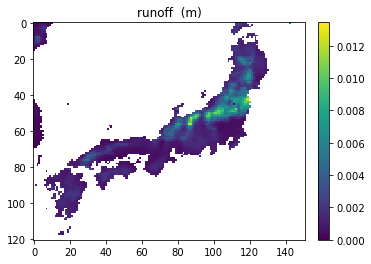

Read data for accumulation to  2017-06-02 00:00:00
Read data for accumulation to  2017-06-03 00:00:00
Read data for accumulation to  2017-06-04 00:00:00
Read data for accumulation to  2017-06-05 00:00:00
Read data for accumulation to  2017-06-06 00:00:00
Read data for accumulation to  2017-06-07 00:00:00
Read data for accumulation to  2017-06-08 00:00:00
Read data for accumulation to  2017-06-09 00:00:00
Read data for accumulation to  2017-06-10 00:00:00
Read data for accumulation to  2017-06-11 00:00:00
Read data for accumulation to  2017-06-12 00:00:00
Read data for accumulation to  2017-06-13 00:00:00
Read data for accumulation to  2017-06-14 00:00:00
Read data for accumulation to  2017-06-15 00:00:00
Read data for accumulation to  2017-06-16 00:00:00
Read data for accumulation to  2017-06-17 00:00:00
Read data for accumulation to  2017-06-18 00:00:00
Read data for accumulation to  2017-06-19 00:00:00
Read data for accumulation to  2017-06-20 00:00:00
Read data for accumulation to  

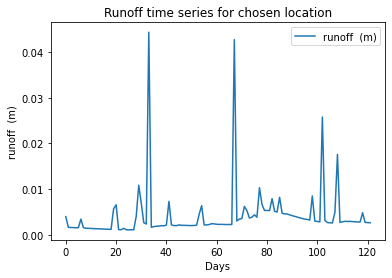

In [7]:
dayarr, timarr, runoffarr = re.extract_series(fpath, fstem, lonpick, latpick, dstart, dend)
dt = dayarr[1]-dayarr[0] # interval between data records (days)

#
### Call the function to extract the run-off time series from S2S database (1.5 degree resolution)
#

In [8]:
# Set the path and filename stem for S2S data files.   
#
fpath = '/glade/scratch/acsubram/S2S_EC_Runoff/'
fstem = 'SurfaceRunoff_'

In [9]:
#data=xr.open_dataset("/glade/scratch/acsubram/S2S_EC_Runoff/SurfaceRunoff_20160411.nc")
data=xr.open_dataset("/glade/scratch/acsubram/S2S_EC_Runoff/SurfaceRunoff_20190513.nc")

In [10]:
runoffarrh=data.sel(longitude=lonpick,latitude=latpick,method="nearest",number=10).sro

In [11]:
# The S2S data provises cumuleted runoff; here we backout daily runoff
runoffarr2= np.ediff1d(runoffarrh, to_begin=runoffarrh[0])

#Convert from kg/m^2 (S2S) to m (ERA)
runoffarr2=runoffarr2/1000

In [12]:
timarr2=data.time
dayarr2=np.array(np.linspace(0, 46, num=47))
dt2 = dayarr2[1]-dayarr2[0] # interval between data records (days)

In [13]:
str='s2s'
if str=='s2s':
    runoffarr=runoffarr2
    dayarr=dayarr2

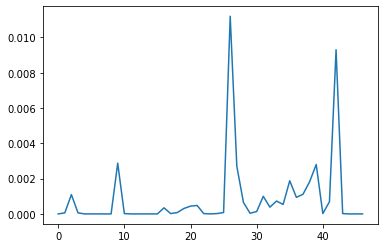

In [14]:
plt.plot(runoffarr2)

### Call the dam management model to return results for optimum power generation subject to constraints on reservoir level and flow rate through turbines.

In [15]:
dt = dt*3600*24          # convert from days to seconds
n = len(dayarr)

In [16]:
inflow, h, w, r, gout = damop_model(runoffarr, dt, catcharea, kappa, hmax, hmin, wmax, wmin, rmax, sigma)
powergen = mu*sigma*w*h


damop_model has been called with the constraints:
wmax =  67.29038065843622    wmin =  6.729038065843622    hmax =  80.5    hmin =  16.1
Now apply quadratic minimization technique
running mean window length, nwin =  19
Iteration limit reached    (Exit mode 9)
            Current function value: -0.9393770154320621
            Iterations: 100
            Function evaluations: 897
            Gradient evaluations: 97
Constrained optimization
     fun: -0.9393770154320621
     jac: array([-2.37919368e-02, -1.14342156e-02,  1.20258421e-02, -8.76841870e-06,
        3.85657810e-06,  1.13209860e-15,  7.40290197e-17, -2.02095285e-15,
        2.32725441e-06,  1.62333891e-04,  1.18783905e-04, -1.39111768e-04,
       -1.13559637e-04, -4.23184346e-04, -2.90719263e-04,  6.51912891e-06,
       -3.39049278e-05, -2.45040806e-04, -3.12195303e-05, -3.05983952e-05,
       -2.13798964e-04,  2.39043925e-04,  2.45577517e-04, -2.22176840e-04,
        2.17356848e-04, -3.48795521e-04, -7.48389718e-04,  1.0449

In [17]:
    ilabel = 'inflow  (m^3 s^-1)'
    hlabel = 'head   (m)'
    wlabel = 'flow rate  (m^3 s^-1)'
    rlabel = 'relief flow  (m^3 s^-1)'
    plabel = 'generation rate  (MW)'
    mytitle = 'dam model optimisation output'

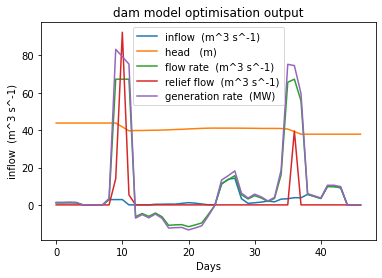

In [18]:
plot_series(dayarr, inflow, h, w, r, powergen, ilabel, hlabel, wlabel, rlabel, plabel, mytitle)